In [1]:
from __future__ import print_function, division
%matplotlib inline
import statsmodels.formula.api as smf  
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import operator
import requests
import sys
import operator
from scipy import stats
from fiona.crs import from_epsg
import math

In [2]:
matplotlib.style.use('seaborn-pastel')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,10)

#### neighborhood to zipcode

[ZIP Code Definitions of New York City Neighborhoods](https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm)

In [3]:
html = requests.get(
        'https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm').content
foo = pd.read_html(html, header=0, index_col=0)[0]

In [4]:
foo.head()

,Neighborhood,ZIP Codes
Borough,,
Bronx,Central Bronx,"10453, 10457, 10460"
Bronx Park and Fordham,"10458, 10467, 10468",NaN
High Bridge and Morrisania,"10451, 10452, 10456",NaN
Hunts Point and Mott Haven,"10454, 10455, 10459, 10474",NaN
Kingsbridge and Riverdale,"10463, 10471",NaN


In [5]:
foo.reset_index(inplace=True)

In [6]:
for i in range(len(foo)):
    try:
        math.isnan(foo.iloc[i,2])
        foo.iloc[i,2] = foo.iloc[i,1]
        foo.iloc[i,1] = foo.iloc[i,0]
        foo.iloc[i,0] = None
    except TypeError:
        continue

In [7]:
foo.head()

,Borough,Neighborhood,ZIP Codes
0,Bronx,Central Bronx,"10453, 10457, 10460"
1,None,Bronx Park and Fordham,"10458, 10467, 10468"
2,None,High Bridge and Morrisania,"10451, 10452, 10456"
3,None,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474"
4,None,Kingsbridge and Riverdale,"10463, 10471"


In [8]:
df = foo[['Neighborhood', 'ZIP Codes']]
df

,Neighborhood,ZIP Codes
0,Central Bronx,"10453, 10457, 10460"
1,Bronx Park and Fordham,"10458, 10467, 10468"
2,High Bridge and Morrisania,"10451, 10452, 10456"
3,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474"
4,Kingsbridge and Riverdale,"10463, 10471"
5,Northeast Bronx,"10466, 10469, 10470, 10475"
6,Southeast Bronx,"10461, 10462,10464, 10465, 10472, 10473"
7,Central Brooklyn,"11212, 11213, 11216, 11233, 11238"
8,Southwest Brooklyn,"11209, 11214, 11228"
9,Borough Park,"11204, 11218, 11219, 11230"


In [9]:
len(df)

42

In [10]:
df['ZIP Codes'][0].split(',')

['10453', ' 10457', ' 10460']

In [11]:
df['ZIP Codes'][0].split(',')[1].lstrip()

'10457'

In [12]:
N = []
Z = []
for i in range(len(df)):
    ziplist = df['ZIP Codes'][i].split(',')
    for j in ziplist:
        N.append(df['Neighborhood'][i])
        Z.append(j.lstrip())

In [13]:
d = {'Neighborhood': N, 'ZIP Codes': Z}
dfnew = pd.DataFrame(data=d)
dfnew

,Neighborhood,ZIP Codes
0,Central Bronx,10453
1,Central Bronx,10457
2,Central Bronx,10460
3,Bronx Park and Fordham,10458
4,Bronx Park and Fordham,10467
5,Bronx Park and Fordham,10468
6,High Bridge and Morrisania,10451
7,High Bridge and Morrisania,10452
8,High Bridge and Morrisania,10456
9,Hunts Point and Mott Haven,10454


In [14]:
dfnew.to_csv('neighborhood_to_zipcode')

## PM25 data

other data are approximate as they do not conform precisely to NYC UHF 42 areas or community districts.

Source: http://a816-dohbesp.nyc.gov/IndicatorPublic/VisualizationData.aspx?id=2023,719b87,91,Summarize

In [15]:
dfpm = pd.read_csv("pm25_2015.csv")
dfpm.head()

,Neighborhood_UHF_42,Mean_mcg_per_cubic_meter
0,Bronx: Crotona -Tremont,9.7
1,Bronx: Fordham - Bronx Pk,9.1
2,Bronx: High Bridge - Morrisania,9.6
3,Bronx: Hunts Point - Mott Haven,9.6
4,Bronx: Kingsbridge - Riverdale,9.2


In [16]:
dfpm['Neighborhood_UHF_42'][0]

'Bronx: Crotona -Tremont'

In [17]:
dfpm['Neighborhood_UHF_42'][0].split(':')

['Bronx', ' Crotona -Tremont']

In [18]:
dfpm['Neighborhood_UHF_42'][0].split(':')[1]

' Crotona -Tremont'

In [19]:
neighborhood = []
for i in range(len(dfpm)):
    name = dfpm['Neighborhood_UHF_42'][i].split(': ')[1]
    neighborhood.append(name)
neighborhood

['Crotona -Tremont',
 'Fordham - Bronx Pk',
 'High Bridge - Morrisania',
 'Hunts Point - Mott Haven',
 'Kingsbridge - Riverdale',
 'Northeast Bronx',
 'Pelham - Throgs Neck',
 'Bedford Stuyvesant - Crown Heights',
 'Bensonhurst - Bay Ridge',
 'Borough Park',
 'Canarsie - Flatlands',
 'Coney Island - Sheepshead Bay',
 'Downtown - Heights - Slope',
 'East Flatbush - Flatbush',
 'East New York',
 'Greenpoint',
 'Sunset Park',
 'Williamsburg - Bushwick',
 'Central Harlem - Morningside Heights',
 'Chelsea - Clinton',
 'East Harlem',
 'Gramercy Park - Murray Hill',
 'Greenwich Village - SoHo',
 'Lower Manhattan',
 'Union Square - Lower East Side',
 'Upper East Side',
 'Upper West Side',
 'Washington Heights',
 'Bayside - Little Neck',
 'Flushing - Clearview',
 'Fresh Meadows',
 'Jamaica',
 'Long Island City - Astoria',
 'Ridgewood - Forest Hills',
 'Rockaways',
 'Southeast Queens',
 'Southwest Queens',
 'West Queens',
 'Port Richmond',
 'South Beach - Tottenville',
 'Stapleton - St. George',

In [20]:
d = {'neighborhood': neighborhood, 'pm': dfpm['Mean_mcg_per_cubic_meter']}
dfpmnew = pd.DataFrame(data=d)
dfpmnew

,neighborhood,pm
0,Crotona -Tremont,9.7
1,Fordham - Bronx Pk,9.1
2,High Bridge - Morrisania,9.6
3,Hunts Point - Mott Haven,9.6
4,Kingsbridge - Riverdale,9.2
5,Northeast Bronx,9.1
6,Pelham - Throgs Neck,8.9
7,Bedford Stuyvesant - Crown Heights,8.9
8,Bensonhurst - Bay Ridge,8.1
9,Borough Park,8.4


### Merge

In [21]:
result = pd.concat([df, dfpmnew], axis=1)
result.head()

,Neighborhood,ZIP Codes,neighborhood,pm
0,Central Bronx,"10453, 10457, 10460",Crotona -Tremont,9.7
1,Bronx Park and Fordham,"10458, 10467, 10468",Fordham - Bronx Pk,9.1
2,High Bridge and Morrisania,"10451, 10452, 10456",High Bridge - Morrisania,9.6
3,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474",Hunts Point - Mott Haven,9.6
4,Kingsbridge and Riverdale,"10463, 10471",Kingsbridge - Riverdale,9.2


In [22]:
dfpm25 = result[['Neighborhood', 'pm']]
dfpm25.head()

,Neighborhood,pm
0,Central Bronx,9.7
1,Bronx Park and Fordham,9.1
2,High Bridge and Morrisania,9.6
3,Hunts Point and Mott Haven,9.6
4,Kingsbridge and Riverdale,9.2


In [23]:
merged = dfnew.merge(dfpm25, on='Neighborhood', how='outer')
merged

,Neighborhood,ZIP Codes,pm
0,Central Bronx,10453,9.7
1,Central Bronx,10457,9.7
2,Central Bronx,10460,9.7
3,Bronx Park and Fordham,10458,9.1
4,Bronx Park and Fordham,10467,9.1
5,Bronx Park and Fordham,10468,9.1
6,High Bridge and Morrisania,10451,9.6
7,High Bridge and Morrisania,10452,9.6
8,High Bridge and Morrisania,10456,9.6
9,Hunts Point and Mott Haven,10454,9.6


In [24]:
finaldf = merged[['ZIP Codes', 'pm']]
finaldf['ZIP Codes'] = finaldf['ZIP Codes'].astype(str)
finaldf.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ZIP Codes,pm
0,10453,9.7
1,10457,9.7
2,10460,9.7
3,10458,9.1
4,10467,9.1


In [25]:
finaldf.describe()

,pm
count,178.000000
mean,9.023596
std,1.071513
min,7.200000
25%,8.200000
50%,8.900000
75%,9.700000
max,11.700000


In [26]:
finaldf.to_csv('pm25_2015_byzipcode.csv')

### Map

In [27]:
os.system("curl -O http://catalog.civicdashboards.com/dataset/11fd957a-8885-42ef-aa49-5c879ec93fac/resource/28377e88-8a50-428f-807c-40ba1f09159b/download/nyc-zip-code-tabulation-areas-polygons.geojson")
os.system("mv " + "nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA"))
nyc = gpd.read_file(os.getenv("PUIDATA") + "/" + 'nyc-zip-code-tabulation-areas-polygons.geojson')

In [28]:
nyc['zip_code'] = nyc.postalCode.astype(str)
nyc.drop(['OBJECTID', 'postalCode', 'PO_NAME', 'STATE', 'borough', 'ST_FIPS',
          'CTY_FIPS', 'BLDGpostal', '@id', 'longitude', 'latitude'], axis=1, inplace=True)

In [29]:
mapData = nyc.merge(finaldf, left_on='zip_code', right_on='ZIP Codes')
mapData.shape

(189, 4)

In [30]:
mapData.dtypes

geometry      object
zip_code      object
ZIP Codes     object
pm           float64
dtype: object

In [31]:
mapData

,geometry,zip_code,ZIP Codes,pm
0,POLYGON ((-73.86942457284177 40.74915687096788...,11372,11372,9.2
1,POLYGON ((-73.71132911125308 40.74947450816085...,11004,11004,7.9
2,POLYGON ((-73.72270447144122 40.75373371438336...,11426,11426,7.9
3,"POLYGON ((-73.81088634744756 40.7271718757592,...",11365,11365,8.2
4,POLYGON ((-73.88722098467159 40.72752618766135...,11373,11373,9.2
5,POLYGON ((-73.85644802697581 40.73625356975942...,11375,11375,8.5
6,POLYGON ((-73.74168681424477 40.73682340115314...,11427,11427,7.9
7,POLYGON ((-73.86451198956482 40.73407164841783...,11374,11374,8.5
8,POLYGON ((-73.77010678596534 40.73177920848852...,11366,11366,8.2
9,POLYGON ((-73.77010678596534 40.73177920848852...,11423,11423,8.2


In [32]:
mapData.crs = from_epsg(4326) #from lat/long
mapData['geometry'] = nyc.to_crs(epsg=2263).geometry
mapData = gpd.GeoDataFrame(mapData)

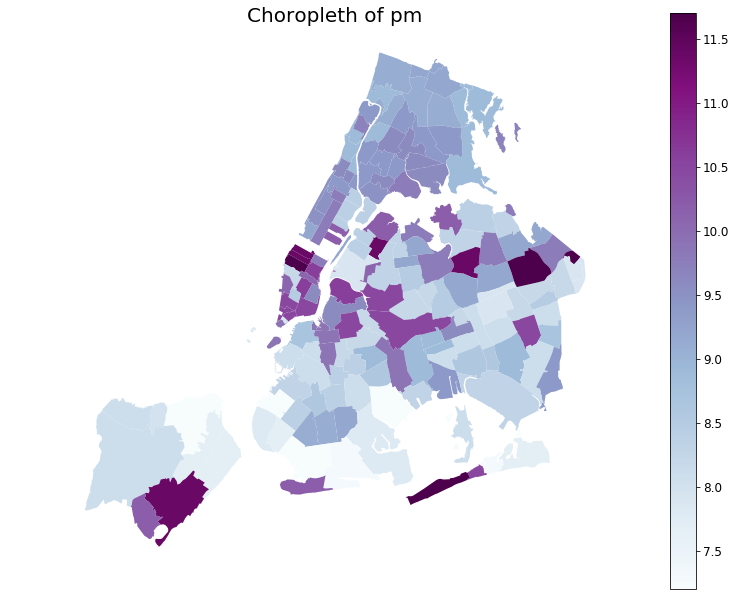

In [33]:
name = 'pm'
ax = mapData.plot(column='{}'.format(name), cmap='BuPu', alpha=1)
vmin, vmax = min(mapData['{}'.format(name)].values), max(mapData['{}'.format(name)].values)
ax.axis('off')
ax.set_title('Choropleth of {}'.format(name), size=20)
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.savefig('pm25_2015', dpi=300, transparent=True)
plt.show()